# Kernel Generation for image similarity using Wiener Deconvolution 

## Imports

In [1]:
import numpy as np
import cv2
from scipy import signal
from scipy import fftpack
from matplotlib import pyplot as plt

## Helper Functions

### `wiener_deconvolution`
Performs wiener deconvolution on a target and input image and outputs a kernal.

In [2]:
def wiener_deconvolution(input_image: np.ndarray, target_image: np.ndarray, noise_level: float = 0.1, kernel_size: int = 15) -> np.ndarray:
    """
    Perform Wiener deconvolution to compute the deblurring kernel.

    Parameters:
    - input_image: np.ndarray - The input (blurry) image.
    - target_image: np.ndarray - The target (sharp) image.
    - noise_level: float - The noise level for regularization (default is 0.1).

    Returns:
    - np.ndarray - The computed deblurring kernel.
    """
   # Compute FFT of input and target images
    input_fft = fftpack.fft2(input_image)
    target_fft = fftpack.fft2(target_image)
    
    # Estimate the filter in frequency domain
    filter_fft = np.conj(input_fft) * target_fft / (np.abs(input_fft)**2 + noise_level**2)
    
    # Convert filter back to spatial domain
    kernel = np.real(fftpack.ifft2(filter_fft))
    
    # Normalize and truncate the kernel
    kernel = kernel / np.sum(kernel)
    kernel = fftpack.fftshift(kernel)
    center = kernel.shape[0] // 2
    kernel = kernel[center - kernel_size // 2:center + kernel_size // 2 + 1,
                    center - kernel_size // 2:center + kernel_size // 2 + 1]
    
    return kernel

### `apply_kernel`
Applies kernel.

In [3]:
def apply_kernel(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    return signal.convolve2d(image, kernel, mode='same', boundary='wrap')

### `apply_sharpening`
Applies sharpening to an image based on a given sharpening factor.

In [4]:
def apply_sharpening(image: np.ndarray, sharpening_factor: float):
    """
    Apply sharpening to the image.
    :param image: Input image
    :param sharpening_factor: Factor to control the strength of sharpening (0.0 means no sharpening)
    :return: Sharpened image
    """
    # Define sharpening kernel
    kernel = np.array([[0, -1, 0],
                       [-1, 5 + sharpening_factor, -1],
                       [0, -1, 0]])
    # Apply the kernel to the image
    sharpened_image = cv2.filter2D(image, -1, kernel)
    return sharpened_image

### `adjust_brightness`
Adjusts the brightness of an image based on a given brightness factor.

In [5]:
def adjust_brightness(image: np.ndarray, brightness_factor: float) -> np.ndarray:
    """
    Adjust the brightness of the image.
    :param image: Input image
    :param brightness_factor: Factor by which to increase the brightness (1.0 means no change)
    :return: Brightness adjusted image
    """
    # Convert image to float32 to prevent clipping values during multiplication
    image_float = image.astype(np.float32)
    # Adjust brightness
    brightened_image = image_float * brightness_factor
    # Clip values to the range [0, 255]
    brightened_image = np.clip(brightened_image, 0, 255)
    # Convert back to uint8
    return brightened_image.astype(np.uint8)

### `brighten_dark_spots` 
Currently not in use, meant to do what it says.

In [6]:
def brighten_dark_spots(image, threshold=50, brighten_factor=1.5):
    """
    Brighten only the dark spots of the image.
    :param image: Input grayscale image
    :param threshold: Intensity threshold to identify dark spots
    :param brighten_factor: Factor by which to brighten the dark spots
    :return: Image with brightened dark spots
    """
    # Ensure image is in float32 to prevent clipping values during multiplication
    image_float = image.astype(np.float32)
    
    # Create a mask for dark spots
    dark_spots_mask = image_float < threshold
    
    # Brighten dark spots
    brightened_image = image_float.copy()
    brightened_image[dark_spots_mask] *= brighten_factor
    
    # Clip values to the range [0, 255]
    brightened_image = np.clip(brightened_image, 0, 255)
    
    # Convert back to uint8
    return brightened_image.astype(np.uint8)

In [7]:
def apply_kernel(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    return signal.convolve2d(image, kernel, mode='same', boundary='wrap')

## Algo

### Load images in grayscale

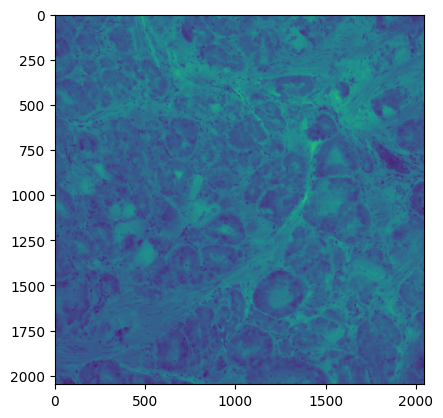

In [8]:
# Load images
input_image = cv2.imread('Prostate.jpg', cv2.IMREAD_GRAYSCALE)
target_image = cv2.imread('good.jpg', cv2.IMREAD_GRAYSCALE)

# Ensure images are the same size
min_shape = np.minimum(input_image.shape, target_image.shape)
input_image = input_image[:min_shape[0], :min_shape[1]]
target_image = target_image[:min_shape[0], :min_shape[1]]

plt.imshow(input_image)

(2048, 2048)


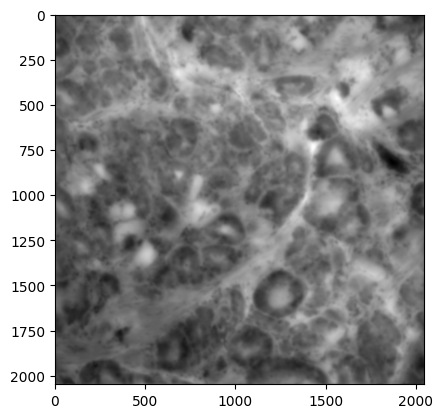

In [9]:
import numpy as np
import cv2
from scipy import signal
from scipy.optimize import minimize
from skimage.metrics import structural_similarity as ssim
from matplotlib import pyplot as plt

def gaussian_filter(size, sigma):
    x, y = np.meshgrid(np.linspace(-1, 1, size), np.linspace(-1, 1, size))
    d = np.sqrt(x*x + y*y)
    g = np.exp(-(d**2 / (2.0 * sigma**2)))
    return g / g.sum()

def apply_kernel(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    return signal.convolve2d(image, kernel, mode='same', boundary='wrap')

# Load images
input_image = cv2.imread('Prostate.jpg', cv2.IMREAD_GRAYSCALE)
target_image = cv2.imread('good.jpg', cv2.IMREAD_GRAYSCALE)

# Ensure both images have the same size
min_shape = np.minimum(input_image.shape, target_image.shape)
input_image = input_image[:min_shape[0], :min_shape[1]]
target_image = target_image[:min_shape[0], :min_shape[1]]

def objective_function(params):
    x, y, z, kernel_size = params
    kernel_size = int(kernel_size)  # Ensure kernel_size is an integer
    
    hi1 = gaussian_filter(kernel_size, x)
    hi2 = gaussian_filter(kernel_size, y)
    hi3 = gaussian_filter(kernel_size, z)
    
    hi = hi1 + hi2 + hi3
    
    filtered_image = apply_kernel(input_image, hi)
    
    # Calculate SSIM
    ssim_value = ssim(filtered_image, target_image)
    
    # We want to maximize SSIM, so we return negative SSIM for minimization
    return -ssim_value

# Initial guess for parameters
initial_guess = [0.3, 1.0, 0.1, 100]

# Bounds for parameters (x, y, z should be positive, kernel_size between 3 and 200)
bounds = [(0.01, 10), (0.01, 10), (0.01, 10), (3, 200)]

# Optimize
result = minimize(objective_function, initial_guess, method='L-BFGS-B', bounds=bounds)

# Get optimized parameters
x_opt, y_opt, z_opt, kernel_size_opt = result.x

print(f"Optimized parameters: x={x_opt}, y={y_opt}, z={z_opt}, kernel_size={int(kernel_size_opt)}")
print(f"Best SSIM: {-result.fun}")

# Apply optimized filter
hi1_opt = gaussian_filter(int(kernel_size_opt), x_opt)
hi2_opt = gaussian_filter(int(kernel_size_opt), y_opt)
hi3_opt = gaussian_filter(int(kernel_size_opt), z_opt)
hi_opt = hi1_opt + hi2_opt + hi3_opt

filtered_image_opt = apply_kernel(input_image, hi_opt)

# Plot results
plt.figure(figsize=(15, 5))
plt.subplot(131), plt.imshow(input_image, cmap='gray')
plt.title('Input Image'), plt.axis('off')
plt.subplot(132), plt.imshow(filtered_image_opt, cmap='gray')
plt.title('Optimized Filtered Image'), plt.axis('off')
plt.subplot(133), plt.imshow(target_image, cmap='gray')
plt.title('Target Image'), plt.axis('off')
plt.tight_layout()
plt.show()